In [9]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')

import numpy as np
import matplotlib.pyplot as plt
import SolveLinSys
from utilities import compute_derivatives

Equation:

\begin{align*}
0 &= \max_{e}\min_{h_2} b\left[\delta \eta \log e - \tau z_2 e + \xi_m \frac{(h_2)^2}{2}\right] - \ell e - \frac{\partial \psi}{\partial b}(b,z_2;\ell) \delta b\\
&+\left[\frac{\partial \psi}{\partial z_2}(b,z_2;\ell)\right]\left[-\rho(z_2-\mu_2)+\sqrt{z_2}\sigma_2 h_2\right] + \left[\frac{\partial^2 \psi}{\partial(z_2)^2}(b,z_2;\ell)\right]\left(\frac{z_2|\sigma_2|^2}{2}\right)
\end{align*}

FOC for $h_2$ gives:
$$
h^* = -\frac{\frac{\partial \psi}{\partial z_2}(b,z_2;\ell)\sqrt{z_2}\sigma_2}{b\xi_m}
$$

FOC for $e$ gives:
$$
e^* = \frac{b\delta \eta}{b\tau z_2 + \ell}
$$

Solve:

\begin{align*}
\frac{\color{red}{\psi_{i+1}(b,z_2;\ell)}-\color{blue}{\psi_{i}(b,z_2;\ell)}}{\epsilon} &= b\left[\delta \eta \log \color{blue}{e^*} - \tau z_2 \color{blue}{e^*} + \xi_m \frac{(\color{blue}{h_2^*})^2}{2}\right] - \ell \color{blue}{e^*} - \color{red}{\frac{\partial \psi}{\partial b}(b,z_2;\ell)} \delta b\\
&+\left[\color{red}{\frac{\partial \psi}{\partial z_2}(b,z_2;\ell)}\right]\left[-\rho(z_2-\mu_2)+\sqrt{z_2}\sigma_2 \color{blue}{h_2^*}\right] + \left[\color{red}{\frac{\partial^2 \psi}{\partial(z_2)^2}(b,z_2;\ell)}\right]\left(\frac{z_2|\sigma_2|^2}{2}\right)
\end{align*}

In [2]:
def false_transient_one_iteration(stateSpace, A, B_z, B_b, C_zz, C_bb, D, v0, ε=.3, tol=-10):
    A = A.reshape(-1, 1, order='F')
    B = np.hstack([B_z.reshape(-1, 1, order='F'), B_b.reshape(-1, 1, order='F')])
    C = np.hstack([C_zz.reshape(-1, 1, order='F'), C_bb.reshape(-1, 1, order='F')])
    D = D.reshape(-1, 1, order='F')
    v0 = v0.reshape(-1, 1, order='F')
    out = SolveLinSys.solveFT(stateSpace, A, B, C, D, v0, ε, tol)
    return out


def false_transient(z_grid, b_grid, ℓ, model_paras=(), v0=None, ϵ=.5, tol=1e-8, max_iter=10_000):
    τ, η, ξ_m, δ, η, μ_2, ρ, σ_2 = model_paras

    Δ_z = z_grid[1] - z_grid[0]
    Δ_b = b_grid[1] - b_grid[0]
    (z_mat, b_mat) = np.meshgrid(z_grid, b_grid, indexing = 'ij')
    stateSpace = np.hstack([z_mat.reshape(-1, 1, order='F'), b_mat.reshape(-1, 1, order='F')])

    if v0 is None:
        v0 = np.zeros_like(z_mat)

    count = 1
    error = 1.

    while error > tol and count < max_iter:
        v_old = v0.copy()
        v0_dz = compute_derivatives(v0, 0, 1, Δ_z)
        v0_dzz = compute_derivatives(v0, 0, 2, Δ_z)
        v0_db = compute_derivatives(v0, 1, 1, Δ_b)

        e = b_mat*δ*η / (b_mat*τ*z_mat + ℓ)
        h = -v0_dz*np.sqrt(z_mat)*σ_2 / (b_mat*ξ_m)

        A = np.zeros_like(z_mat)
        B_z = -ρ*(z_mat - μ_2) + np.sqrt(z_mat)*σ_2*h
        B_b = -(δ*b_mat)
        C_zz = z_mat*σ_2**2/2
        C_bb = np.zeros_like(z_mat)
        D = b_mat*(δ*η*np.log(e) - τ*z_mat*e + ξ_m*h**2/2) - ℓ*e

        res = false_transient_one_iteration(stateSpace, A, B_z, B_b, C_zz, C_bb, D, v0, ϵ) # CG tol = 1e-10
        v0 = res[2].reshape(v0.shape, order = "F")

        rhs_error = A*v0 + B_z*v0_dz + B_b*v0_db + C_zz*v0_dzz + D
        rhs_error = np.max(abs(rhs_error))
        lhs_error = np.max(abs((v0 - v_old)/ϵ))
        error = lhs_error

#         print("Iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))
        count += 1
    print("Iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))
    return v0, e

In [3]:
# Model parameters
median = 1.75/1000
γ = .018
τ = median * γ
η = .032
ξ_m = .00256/40.
δ = .01
η = .032

μ_2 = 1.
ρ = .5
σ_2 = np.sqrt((.21)**2*2*ρ/μ_2) # Match moments, using 100 year's std

model_paras = (τ, η, ξ_m, δ, η, μ_2, ρ, σ_2)

In [4]:
# Grid setting
n_z = 20
z_min = 0.3 # 0.1%
z_max = 1.9 # 99.9%
z_grid = np.linspace(z_min, z_max, n_z)

n_b = 100
b_min = 1e-2
b_max = 1.
b_grid = np.linspace(b_min, b_max, n_b)

In [5]:
log_ell_grid = np.linspace(-13, -5, 200)
ℓ_step = 1e-7

In [6]:
ψs = []
es = []
ψs_next = []
es_next = []

# ψ_guess, _ = false_transient(z_grid, b_grid, 1e-5, model_paras=model_paras, v0=None, ϵ=.5, tol=1e-8, max_iter=2000)

for i, ℓ in enumerate(np.exp(log_ell_grid)):
    print(i)
    max_iter = 1000
    ψ, e = false_transient(z_grid, b_grid, ℓ, model_paras=model_paras, v0=None, ϵ=.5, tol=1e-8, max_iter=max_iter)
    ψ_next, e_next = false_transient(z_grid, b_grid, ℓ+ℓ_step, model_paras=model_paras, v0=None, ϵ=.5, tol=1e-8, max_iter=max_iter)
    ψs.append(ψ)
    es.append(e)
    ψs_next.append(ψ_next)
    es_next.append(e_next)

0
Iteration 1000: LHS Error: 3.5914929832131168e-06; RHS Error 2.7478594256429164e-05
Iteration 1000: LHS Error: 3.6247693102771893e-06; RHS Error 2.7294332287864948e-05
1
Iteration 1000: LHS Error: 3.62243112387705e-06; RHS Error 2.730772341054345e-05
Iteration 1000: LHS Error: 3.6534567176595145e-06; RHS Error 2.7124362768443547e-05
2
Iteration 1000: LHS Error: 3.6524152153285215e-06; RHS Error 2.7130619918891603e-05
Iteration 1000: LHS Error: 3.6813489867194675e-06; RHS Error 2.6948216381617214e-05
3
Iteration 1000: LHS Error: 3.6814841617000514e-06; RHS Error 2.6947342227963346e-05
Iteration 1000: LHS Error: 3.7084361096824912e-06; RHS Error 2.6766389429492784e-05
4
Iteration 1000: LHS Error: 3.709632756669287e-06; RHS Error 2.6758081856045153e-05
Iteration 1000: LHS Error: 3.734729459692332e-06; RHS Error 2.6578450521779688e-05
5
Iteration 1000: LHS Error: 3.7368813565392435e-06; RHS Error 2.6562562559056245e-05
Iteration 1000: LHS Error: 3.7602390607184913e-06; RHS Error 2.638457

Iteration 1000: LHS Error: 7.082864083279156e-06; RHS Error 1.4750074690541301e-05
Iteration 1000: LHS Error: 7.0963033350912585e-06; RHS Error 1.4716714532788636e-05
50
Iteration 1000: LHS Error: 7.170685947341382e-06; RHS Error 1.4536231716304345e-05
Iteration 1000: LHS Error: 7.183599156787568e-06; RHS Error 1.4505591392568594e-05
51
Iteration 1000: LHS Error: 7.258522892584704e-06; RHS Error 1.4330523170324398e-05
Iteration 1000: LHS Error: 7.270930987502561e-06; RHS Error 1.4301721409870085e-05
52
Iteration 1000: LHS Error: 7.346375726349427e-06; RHS Error 1.4126643136702145e-05
Iteration 1000: LHS Error: 7.358296390843136e-06; RHS Error 1.4099225838185177e-05
53
Iteration 1000: LHS Error: 7.434242204720429e-06; RHS Error 1.392808377761876e-05
Iteration 1000: LHS Error: 7.445696540452074e-06; RHS Error 1.3902802890484176e-05
54
Iteration 1000: LHS Error: 7.522121567142895e-06; RHS Error 1.373776779944381e-05
Iteration 1000: LHS Error: 7.533128872277972e-06; RHS Error 1.37145274412

Iteration 1000: LHS Error: 1.1310444261558583e-05; RHS Error 1.276180979560229e-05
98
Iteration 1000: LHS Error: 1.139663097184107e-05; RHS Error 1.2837753973274101e-05
Iteration 1000: LHS Error: 1.1398517426847166e-05; RHS Error 1.2839430978925206e-05
99
Iteration 1000: LHS Error: 1.1484783543388999e-05; RHS Error 1.291680387309445e-05
Iteration 1000: LHS Error: 1.1486595779944264e-05; RHS Error 1.2918443822981361e-05
100
Iteration 1000: LHS Error: 1.1572938232007335e-05; RHS Error 1.2997171121131077e-05
Iteration 1000: LHS Error: 1.1574679082249073e-05; RHS Error 1.29987700192552e-05
101
Iteration 1000: LHS Error: 1.1661095059928295e-05; RHS Error 1.307867993892874e-05
Iteration 1000: LHS Error: 1.166276737969707e-05; RHS Error 1.3080236466783502e-05
102
Iteration 1000: LHS Error: 1.1749253619075528e-05; RHS Error 1.3161226597347445e-05
Iteration 1000: LHS Error: 1.1750860108544758e-05; RHS Error 1.316273978205443e-05
103
Iteration 1000: LHS Error: 1.183741427182583e-05; RHS Error 1.

Iteration 1000: LHS Error: 1.5541413078273836e-05; RHS Error 1.6999046865060082e-05
146
Iteration 1000: LHS Error: 1.562932431437014e-05; RHS Error 1.7088441274224148e-05
Iteration 1000: LHS Error: 1.5629598467070682e-05; RHS Error 1.7088719967547992e-05
147
Iteration 1000: LHS Error: 1.5717521306635174e-05; RHS Error 1.7178071776478062e-05
Iteration 1000: LHS Error: 1.571778465822571e-05; RHS Error 1.7178339327319678e-05
148
Iteration 1000: LHS Error: 1.580571861661828e-05; RHS Error 1.7267648452617187e-05
Iteration 1000: LHS Error: 1.580597159261954e-05; RHS Error 1.726790530759035e-05
149
Iteration 1000: LHS Error: 1.5893916221892956e-05; RHS Error 1.7357171889938227e-05
Iteration 1000: LHS Error: 1.58941592310613e-05; RHS Error 1.7357418478742073e-05
150
Iteration 1000: LHS Error: 1.5982114157625515e-05; RHS Error 1.7446642784584845e-05
Iteration 1000: LHS Error: 1.5982347588983092e-05; RHS Error 1.744687951805632e-05
151
Iteration 1000: LHS Error: 1.6070312290700217e-05; RHS Error

Iteration 1000: LHS Error: 1.986298190853608e-05; RHS Error 2.1346191220140195e-05
Iteration 1000: LHS Error: 1.9863021720689655e-05; RHS Error 2.134623098722435e-05
195
Iteration 1000: LHS Error: 1.995118533737461e-05; RHS Error 2.1434286910426486e-05
Iteration 1000: LHS Error: 1.995122358072754e-05; RHS Error 2.1434325104434772e-05
196
Iteration 1000: LHS Error: 2.003938876377065e-05; RHS Error 2.15223694848307e-05
Iteration 1000: LHS Error: 2.00394254998848e-05; RHS Error 2.152240616765176e-05
197
Iteration 1000: LHS Error: 2.0127592290863916e-05; RHS Error 2.161043972359806e-05
Iteration 1000: LHS Error: 2.0127627579968888e-05; RHS Error 2.1610474956741503e-05
198
Iteration 1000: LHS Error: 2.0215795731415298e-05; RHS Error 2.1698497923596568e-05
Iteration 1000: LHS Error: 2.0215829629521842e-05; RHS Error 2.1698531764230856e-05
199
Iteration 1000: LHS Error: 2.0303999342941026e-05; RHS Error 2.1786544795755368e-05
Iteration 1000: LHS Error: 2.0304031906115405e-05; RHS Error 2.1786

In [10]:
ϕs = []
rs = []
distortions = []
ψs_new = []
ℓs = []
for i in range(len(ψs)):
    ψ_b1_i = ψs[i][:, -1]
    ψ_b1_ip1 = ψs_next[i][:, -1]
    dψ = (ψ_b1_ip1-ψ_b1_i)/ℓ_step
    ψ = (ψ_b1_ip1+ψ_b1_i)/2.
    ℓ = np.exp(log_ell_grid)[i] + ℓ_step/2.
    r = -dψ
    ϕ = ψ + ℓ*r
    ψs_new.append(ψ)
    ϕs.append(ϕ)
    rs.append(r)
    Δ_z = z_grid[1] - z_grid[0]
    dϕdz = np.zeros_like(ψ)
    for j in range(n_z):
        if j == 0:
            dϕdz[j] = (ψ[j+1]-ψ[j])/Δ_z
        elif j == n_z-1:
            dϕdz[j] = (ψ[j]-ψ[j-1])/Δ_z
        else:
            dϕdz[j] = (ψ[j+1]-ψ[j-1])/(2*Δ_z)
    distortion = -(dϕdz*z_grid*σ_2**2)/ξ_m
    distortions.append(distortion)
    ℓs.append(ℓ)

### Plot distortion vs $\ell$ and $r$

(0.0, 2500.0)

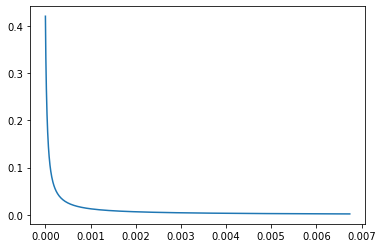

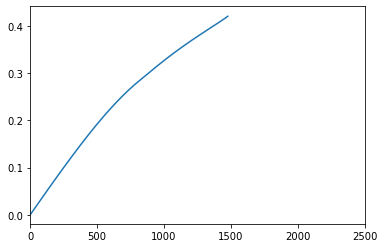

In [13]:
z_loc = 8

distortion_z = np.array([dist[z_loc] for dist in distortions])
r_z = np.array([r[z_loc] for r in rs])
ℓs = np.array(ℓs)
plt.figure()
plt.plot(ℓs, distortion_z)
plt.figure()
plt.plot(r_z, distortion_z)
plt.xlim(0, 2500)

### Simulation

In [15]:
z_loc = 8

ϕ_z = np.array([ϕ[z_loc] for ϕ in ϕs])
r_z = np.array([r[z_loc] for r in rs])
dist_z = np.array([dist[z_loc] for dist in distortions])
sort_indices = np.argsort(r_z)
ϕ_z_sorted = ϕ_z[sort_indices]
r_z_sorted = r_z[sort_indices]
dist_z_sorted = dist_z[sort_indices]

# Calculate dϕ/dr, e_star
r_z, indices = np.unique(r_z_sorted, return_index=True)
ϕ_z = ϕ_z_sorted[indices]
dist_z = dist_z_sorted[indices]
ϕ_der = (ϕ_z[1:]-ϕ_z[:-1])/(r_z[1:]-r_z[:-1])
r_z = (r_z[1:]+r_z[:-1])/2
ϕ_z = (ϕ_z[1:]+ϕ_z[:-1])/2
dist_z = (dist_z[1:]+dist_z[:-1])/2
e_z = δ*η/(τ*z_grid[z_loc]+ϕ_der)

In [16]:
def simulation(e_grid, r_grid, dist_grid, r_start=1500, T=100):
    """
    Simulate emission trajectory baesd on grids of emission and reserve.

    Parameters
    ----------
    e_grid : (N, ) ndarray
        Grid of emission.
    r_grid : (N, ) ndarray
        Grid of reserve.

    Returns
    -------
    Et : (T, ) ndarray
        Emission trajectory.

    """
    Et = np.zeros(T)
    dist_t = np.zeros(T)
    r_remain = r_start
    for i in range(T):
        loc = find_nearest_value(r_grid, r_remain)
        Et[i] = e_grid[loc]
        dist_t[i] = dist_grid[loc]
        r_remain = r_remain - Et[i]
    return Et, dist_t


def find_nearest_value(array, value):
    loc = np.abs(array - value).argmin()
    return loc

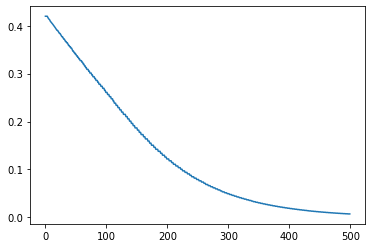

In [17]:
Et, dist_t = simulation(e_z, r_z, dist_z, r_start=1500, T=500)
# plt.plot(Et)
plt.plot(dist_t)

# import matplotlib.pyplot as plt
# plt.plot(Et_7, label=r'10% percentile of $Z_2$')
# plt.plot(Et_10, label=r'50% percentile of $Z_2$')
# plt.plot(Et_13, label=r'90% percentile of $Z_2$')
# plt.legend()
# plt.xlabel('Year')
# plt.ylabel('Emission')
# plt.title('Emission trajectory')
# plt.savefig('plot.pdf')

In [ ]:
plt.plot(Et_7[:200], label=r'10% percentile of $Z_2$')
plt.plot(Et_10[:200], label=r'50% percentile of $Z_2$')
plt.plot(Et_13[:200], label=r'90% percentile of $Z_2$')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Emission')
plt.title(r'Emission trajectory, $\xi=0.00256$')
plt.savefig('plot_200.pdf')

In [ ]:
# Simulation to compute quantile
# dZ = -ρ*(Z-μ_2)*dt + np.sqrt(Z)*σ_2*dW
def simulate(T=1_000_000):
    Ws = np.random.normal(size=T)
    Z = np.zeros(T)
    Z[0] = μ_2
    for i in range(1, T):
        Z[i] = Z[i-1] + (Z[i-1]-μ_2)*(-ρ) + np.sqrt(Z[i-1])*σ_2*Ws[i]
    return Z

In [ ]:
Z = simulate(T=1_000_000)

In [ ]:
# np.quantile(Z, 0.90)

In [ ]:
0.6994771371520058 # 10%, 7
0.9875416359997453 # 50%, 10
1.3172478454208487 # 90%, 13